In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:


def find_grid_parameters(image_path):
    """
    Attempts to locate the puzzle/grid in a screenshot and deduce:
      - board_x, board_y: top-left corner of the grid in pixels
      - cell_width, cell_height: approximate size of each cell in pixels
      - cols, rows: number of grid columns and rows

    Returns:
      (board_x, board_y, cell_width, cell_height, cols, rows)
    or None if detection fails.
    """

    # 1. Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image at path: {image_path}")
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Detect edges (tune thresholds as needed)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3)

    # 3. Perform Hough line detection
    #    Note: you may need to adjust rho, theta, threshold, etc.
    lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=100)
    if lines is None:
        print("No lines detected—tweak your thresholds or method.")
        return None

    # Separate lines into near-horizontal and near-vertical
    # We'll store each line as the 'rho' and 'theta' from Hough
    #   line format: [[rho, theta]]
    horiz_rhos = []
    vert_rhos = []
    for line in lines:
        rho, theta = line[0]
        # Normalize angle to [0..pi)
        # near 0 or near pi => horizontal, near pi/2 => vertical
        # We'll define a tolerance (e.g. 10 degrees)
        deg = np.degrees(theta) % 180

        # near-horizontal if angle is within ~10 deg of 0 or 180
        if deg < 10 or deg > 170:
            horiz_rhos.append(rho)
        # near-vertical if angle is within ~10 deg of 90
        elif 80 < deg < 100:
            vert_rhos.append(rho)
        # else ignore diagonal lines, etc.

    # 4. Cluster lines that are nearly on top of each other
    #    For instance, we might have multiple lines for the same grid edge.
    def cluster_lines(rhos, cluster_dist=10):
        """
        Sort the rhos and merge lines that are within 'cluster_dist' of each other
        into a single representative location (the mean of their positions).
        """
        if not rhos:
            return []
        rhos = sorted(rhos)
        clusters = []
        current_cluster = [rhos[0]]
        for r in rhos[1:]:
            if abs(r - current_cluster[-1]) < cluster_dist:
                # same cluster
                current_cluster.append(r)
            else:
                # finish this cluster, start new
                clusters.append(np.mean(current_cluster))
                current_cluster = [r]
        # last cluster
        clusters.append(np.mean(current_cluster))
        return clusters

    horiz_positions = cluster_lines(horiz_rhos, cluster_dist=10)
    vert_positions  = cluster_lines(vert_rhos,  cluster_dist=10)

    # We expect multiple horizontal lines across the puzzle and multiple vertical lines
    if len(horiz_positions) < 2 or len(vert_positions) < 2:
        print("Not enough grid lines found to infer a grid.")
        return None

    # 5. The puzzle bounding box is roughly the min and max of each set
    min_h = min(horiz_positions)
    max_h = max(horiz_positions)
    min_v = min(vert_positions)
    max_v = max(vert_positions)

    # Because Hough lines in the (rho,theta) format measure the line’s
    # distance from origin, sign depends on quadrant. Let’s assume the puzzle
    # is in the positive quadrant. You may need extra checks/adjustments if
    # your lines have negative rho or your origin is top-left in pixel space.

    # Convert the Hough 'rho' for near-horizontal lines to approximate y-coordinates,
    # and near-vertical lines to approximate x-coordinates.
    # For near-horizontal lines: y ~ rho if theta ~ 0
    # For near-vertical lines:  x ~ rho if theta ~ 90 deg
    # *In reality, Hough’s reference is the image origin in top-left, but you may need
    #  more robust transforms if lines can come from all directions.

    # We'll take the clusters themselves as approximate pixel coordinates.
    # For a more correct approach, you'd solve for intersection points, but let's keep it simple.

    top_y    = min_h
    bottom_y = max_h
    left_x   = min_v
    right_x  = max_v

    # 6. Approximate the number of cells by counting the lines
    #    e.g. if we see 8 vertical lines, that might be 7 columns, etc.
    # But in many puzzle games, #lines = #cells + 1. 
    # We'll do:
    rows = len(horiz_positions) - 1
    cols = len(vert_positions) - 1

    if rows < 1 or cols < 1:
        print("Too few lines or ambiguous grid—cannot determine rows/columns.")
        return None

    # 7. Calculate cell width, height
    # Simple approach: 
    #   (right_x - left_x) / number_of_cols
    #   (bottom_y - top_y) / number_of_rows
    board_x = int(left_x)
    board_y = int(top_y)
    cell_width  = (right_x - left_x) / cols
    cell_height = (bottom_y - top_y) / rows

    # Round or int cast as needed
    cell_width  = int(round(cell_width))
    cell_height = int(round(cell_height))
    board_x     = int(round(board_x))
    board_y     = int(round(board_y))

    return board_x, board_y, cell_width, cell_height, cols, rows

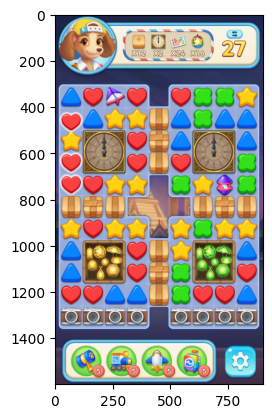

In [3]:


image_path = "MPT/lv171.png"
img = cv2.imread(image_path)
if img is None:
    print(f"Could not read image at path: {image_path}")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


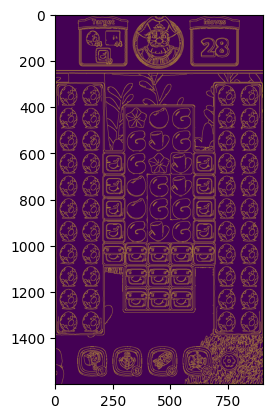

In [12]:
edges = cv2.Canny(img, threshold1=50, threshold2=150, apertureSize=3)
plt.imshow(edges)

In [4]:
img.shape

(1600, 900, 3)

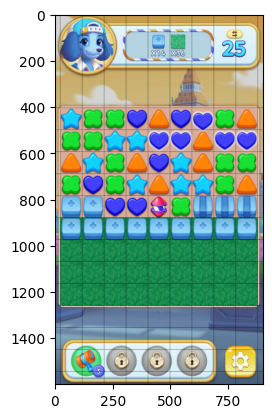

In [15]:
image_path = "MPT/lv12.png"
image = cv2.imread(image_path)

cell_width = 95
cell_height = 95
# Get image dimensions
height, width = image.shape[:2]

# Grid color (black)
grid_color = (0, 0, 0)  # BGR format (Black)

# Thickness of grid lines
thickness = 1

# Draw vertical grid lines
for x in range((width - cell_width*9)//2, width, cell_width):
    cv2.line(image, (x, 0), (x, height), grid_color, thickness)

# Draw horizontal grid lines
for y in range(405, height, cell_height): # 9: 405, 11:310
    cv2.line(image, (0, y), (width, y), grid_color, thickness)

cv2.imwrite('MPT/lv12_grid.png', image)
# Display the image with the grid
plt.imshow(image)

In [17]:
possible_y = [405 + 95//2 + 95*i for i in range(9)]
possible_x = [(width - cell_width*9)//2 + 95//2 + 95*i for i in range(9)] 
possible_x, possible_y

([69, 164, 259, 354, 449, 544, 639, 734, 829],
 [452, 547, 642, 737, 832, 927, 1022, 1117, 1212])

In [18]:
action_space = {}
swipe_right, swipe_left, swipe_up, swipe_down = (+cell_width, 0), (-cell_width, 0), (0, +cell_height), (0, cell_height)
for i in range(9):
    for j in range(9):
        if i == 0 and j == 0:
            action_space[(possible_x[i], possible_y[j])] = [swipe_right, swipe_down]
        elif i == 0 and j == 8:
            action_space[(possible_x[i], possible_y[j])] = [swipe_right, swipe_up]
        elif i == 8 and j == 0:
            action_space[(possible_x[i], possible_y[j])] = [swipe_left, swipe_down]
        elif i == 8 and j == 8:
            action_space[(possible_x[i], possible_y[j])] = [swipe_left, swipe_up]
        elif i == 0:
            action_space[(possible_x[i], possible_y[j])] = [swipe_right, swipe_up, swipe_down]
        elif i == 8:
            action_space[(possible_x[i], possible_y[j])] = [swipe_left, swipe_up, swipe_down]
        elif j == 0:
            action_space[(possible_x[i], possible_y[j])] = [swipe_right, swipe_left, swipe_down]
        elif j == 8:
            action_space[(possible_x[i], possible_y[j])] = [swipe_right, swipe_left, swipe_up]
        else:
            action_space[(possible_x[i], possible_y[j])] = [swipe_right, swipe_left, swipe_up, swipe_down]


In [19]:
action_space[(164,452)]

[(95, 0), (-95, 0), (0, 95)]

In [41]:
from collections import defaultdict
image_path = "templates/lv112.png"

image = cv2.imread(image_path)

#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#edges = cv2.Canny(gray, 100, 200)
edges = image

# Get image dimensions
height, width = edges.shape[:2]

# Dictionary to store cell data
cell_dict = defaultdict(int)

cell_index=0
# Iterate through the image in cell-sized blocks
for y in range(int(cell_height/2 +height/cell_height/2), height, cell_height):
    for x in range(int(width/cell_width/2), width, cell_width):
        # Extract the cell
        cell = edges[y:y + cell_height, x:x + cell_width]
        print(cell.shape)
        # Increment the frequency count of this cell
        cell_dict[cell_index] += cell
        cell_index += 1

# Sort the dictionary by frequency in descending order
#sorted_cells = sorted(cell_dict.items(), key=lambda item: item[1], reverse=True)


(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 5, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 5, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 5, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 5, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 5, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 5, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 5, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 5, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)
(98, 99, 3)


In [ ]:
cv2.compareHist(hist1, hist2, method)

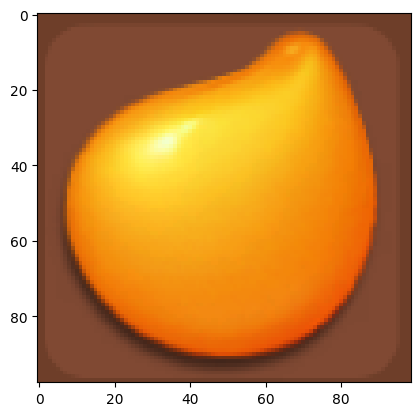

In [48]:
plt.imshow(cell_dict[65])

In [ ]:
def template_matching(image_path, template_path):
    # Load the image and the template
    image = cv2.imread(image_path)
    template = cv2.imread(template_path)
    
    # Convert the image and template to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Get the dimensions of the template
    template_height, template_width = gray_template.shape
    
    # Perform the template matching
    result = cv2.matchTemplate(gray_image, gray_template, cv2.TM_CCOEFF_NORMED)
    
    # Get the best match location (highest match score)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # Draw a rectangle around the matched region
    top_left = max_loc
    bottom_right = (top_left[0] + template_width, top_left[1] + template_height)
    
    # Draw rectangle on the original image
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    
    # Show the image with the matched area
    cv2.imshow("Matched Image", image)
    
    # Print match score
    print(f"Maximum match score: {max_val}")
    
    # Wait for a key press and close the image window
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
image_path = "image.png"  # Path to your main image
template_path = "template.png"  # Path to your template image
template_matching(image_path, template_path)


In [2]:

result = find_grid_parameters(image_path)
if result is not None:
    bx, by, cw, ch, c, r = result
    print("Detected grid parameters:")
    print(f"  board_x = {bx}")
    print(f"  board_y = {by}")
    print(f"  cell_width = {cw}")
    print(f"  cell_height = {ch}")
    print(f"  cols = {c}")
    print(f"  rows = {r}")
else:
    print("Failed to detect grid parameters.")


Not enough grid lines found to infer a grid.
Failed to detect grid parameters.


In [ ]:
import cv2
import numpy as np
from collections import defaultdict

# Function to apply Canny edge detection and process the image into cells
def process_image(image_path, cell_size=100):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Get image dimensions
    height, width = edges.shape

    # Dictionary to store cell data and their frequencies
    cell_dict = defaultdict(int)
    cells = []

    # Iterate through the image in cell-sized blocks
    for y in range(0, height, cell_size):
        for x in range(0, width, cell_size):
            # Extract the cell
            cell = edges[y:y + cell_size, x:x + cell_size]
            
            # Convert cell to a tuple of pixel values (this will be the key in the dictionary)
            cell_tuple = tuple(map(tuple, cell))

            # Increment the frequency count of this cell
            cell_dict[cell_tuple] += 1

            # Store the cell in the list (to create templates later)
            if cell_dict[cell_tuple] == 1:
                cells.append(cell)

    # Sort the dictionary by frequency in descending order
    sorted_cells = sorted(cell_dict.items(), key=lambda item: item[1], reverse=True)

    # Return sorted templates and their frequency
    return cells, sorted_cells

# Function to encode a new image based on templates
def encode_image(image_path, templates, cell_size=100):
    # Load the new image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Get image dimensions
    height, width = edges.shape

    # Initialize the encoded array (same size as the image, but with indices)
    encoded_image = np.zeros((height // cell_size, width // cell_size), dtype=int)

    # Iterate through the image in cell-sized blocks
    for y in range(0, height, cell_size):
        for x in range(0, width, cell_size):
            # Extract the cell
            cell = edges[y:y + cell_size, x:x + cell_size]
            
            # Convert the cell to a tuple (to match it with templates)
            cell_tuple = tuple(map(tuple, cell))

            # Find the best matching template
            best_match_index = -1
            best_match_score = -1

            for idx, template in enumerate(templates):
                # Use normalized correlation (matchTemplate) to compare
                result = cv2.matchTemplate(cell, template, cv2.TM_CCOEFF_NORMED)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

                if max_val > best_match_score:
                    best_match_score = max_val
                    best_match_index = idx

            # Store the index of the best matching template in the encoded image array
            encoded_image[y // cell_size, x // cell_size] = best_match_index

    return encoded_image

# Example usage
image_path = "image.png"  # Path to your image
template_cells, sorted_cells = process_image(image_path, cell_size=100)

# Now encode a new image based on the templates
new_image_path = "new_image.png"  # Path to the new image
encoded_image = encode_image(new_image_path, template_cells, cell_size=100)

# Print the encoded image array
print(encoded_image)
